1.- Importacion de datos y standarizacion de nombre de columnas

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("./data/profit-data.csv")

dataset.head()
num_cols = len(dataset.columns)

# Crear una lista de nombres nuevos
nuevos_nombres = [ i for i in range(num_cols)]

# Asignar los nuevos nombres a las columnas
dataset.columns = nuevos_nombres

dataset = dataset.rename(columns={0: "R_D_Spend", 1: "Administration", 2: "Marketing_Spend", 3:'State', 4:'Profit'})

dataset['State'] = dataset['State'].str.replace(' ', '')
print(dataset)




    R_D_Spend  Administration  Marketing_Spend       State     Profit
0   165349.20       136897.80        471784.10     NewYork  192261.83
1   162597.70       151377.59        443898.53  California  191792.06
2   153441.51       101145.55        407934.54     Florida  191050.39
3   144372.41       118671.85        383199.62     NewYork  182901.99
4   142107.34        91391.77        366168.42     Florida  166187.94
5   131876.90        99814.71        362861.36     NewYork  156991.12
6   134615.46       147198.87        127716.82  California  156122.51
7   130298.13       145530.06        323876.68     Florida  155752.60
8   120542.52       148718.95        311613.29     NewYork  152211.77
9   123334.88       108679.17        304981.62  California  149759.96
10  101913.08       110594.11        229160.95     Florida  146121.95
11  100671.96        91790.61        249744.55  California  144259.40
12   93863.75       127320.38        249839.44     Florida  141585.52
13   91992.39       

Analisis de la columna Profit, con respecto a la frecuencia de datos

<Axes: >

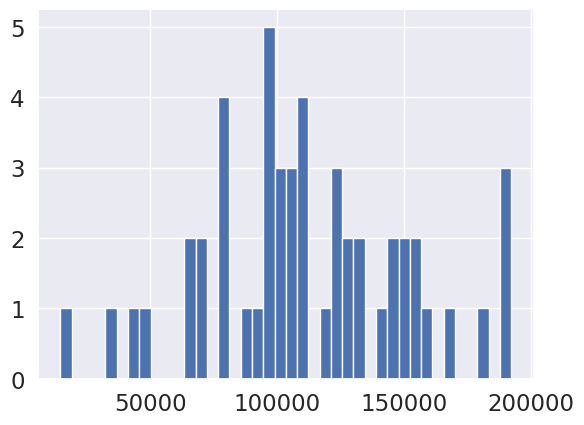

In [15]:
dataset.Profit.hist(bins=40)


Analizando las correlaciones de manera gráfica

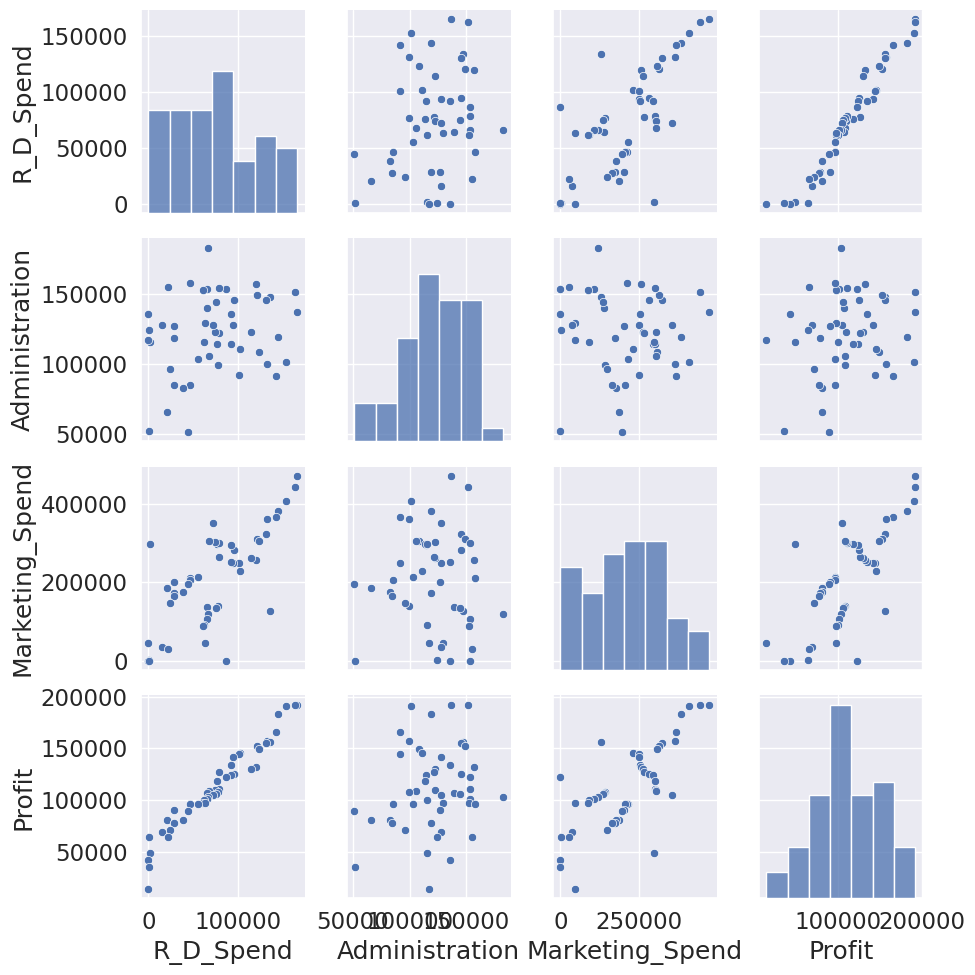

In [16]:
import matplotlib.pyplot  as plt
import seaborn as sns
sns.pairplot(dataset, height=2.5)
plt.show()



Analizando las correlaciones mediante un mapa de calor

<Axes: >

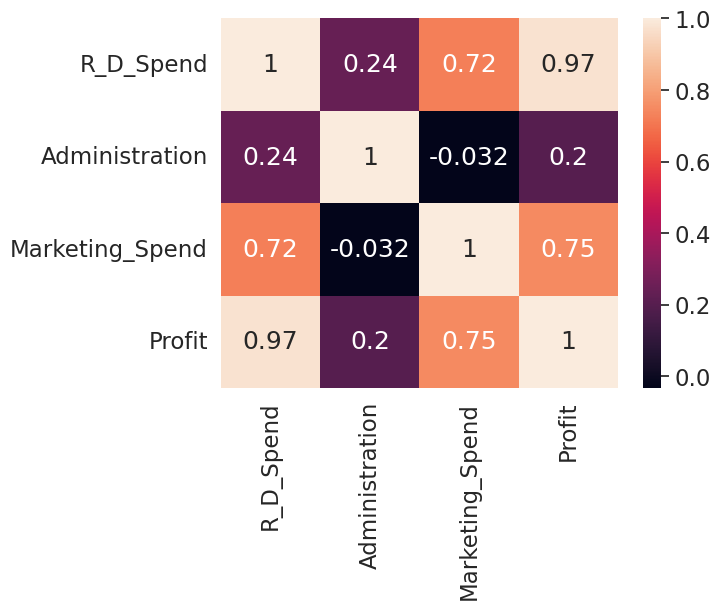

In [17]:
import numpy as np
numeric_cols = ['R_D_Spend', 'Administration','Marketing_Spend' , 'Profit']
cm = np.corrcoef(dataset[numeric_cols].values.T)
sns.set_theme(font_scale=1.5)
sns.heatmap(cm, annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)


3. Categorizacion por variables DUMMIES

In [18]:

dataset = pd.get_dummies(dataset, columns=['State'], drop_first=True)
dataset.head()


,R_D_Spend,Administration,Marketing_Spend,Profit,State_Florida,State_NewYork
0,165349.20,136897.80,471784.10,192261.83,False,True
1,162597.70,151377.59,443898.53,191792.06,False,False
2,153441.51,101145.55,407934.54,191050.39,True,False
3,144372.41,118671.85,383199.62,182901.99,False,True
4,142107.34,91391.77,366168.42,166187.94,True,False


2. Categorización de datos

In [19]:

#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.compose import ColumnTransformer

#ct = ColumnTransformer(
#    [('one_hot_encoder', OneHotEncoder(categories='auto'), [3])],   
    #remainder='passthrough'                        
#)
#x_transformado = np.array(ct.fit_transform(x), dtype=np.double)
#x_transformado = x_transformado[:,1:]
#dataset = pd.DataFrame(x_transformado)

#dataset = dataset.rename(columns={0: "nueva_york", 1: "Florida", 2: "R_D_Spend", 3: "Administration", 4: "Marketing_Spend"})

#print(dataset)

3. Division de datos de entrenamiento y test usando standard sklearn

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
X_cols = list(set(dataset.columns)-set(['Profit']))
y_cols = ['Profit']

x = dataset[X_cols].values
y = dataset[y_cols].values

print(x.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc_x = StandardScaler().fit(x)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)




(50, 5)
(50, 1)


4. Entrenamiento del modelo

In [21]:
regresion = LinearRegression()
regresion.fit(X_train, y_train)
y_pred = regresion.predict(X_test)
y_pred.shape

(10, 1)

5. Evaluando el modelo

In [22]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print("r2: ",r2.round(4))
print("mse: ",mse.round(4))

r2:  0.9347
mse:  0.0524


In [23]:
from regressors import stats
print(regresion.intercept_)
regresion.intercept_=regresion.intercept_[0]
regresion.coef_=regresion.coef_.reshape(-1) 
y_test =y_test.reshape(-1)
print("===============sumary============")
stats.summary(regresion, X_test,y_test,X_cols)

[-0.01980904]
===============sumary============
Residuals:
    Min      1Q  Median     3Q    Max
-0.3427 -0.3084 -0.0763 0.0408 0.2795


Coefficients:
                 Estimate  Std. Error  t value   p value
_intercept      -0.019809    0.091355  -0.2168  0.833171
Marketing_Spend  0.111076    0.130905   0.8485  0.418142
R_D_Spend        0.880855    0.124990   7.0474  0.000060
State_NewYork    0.008303    0.125877   0.0660  0.948851
State_Florida   -0.011215    0.101874  -0.1101  0.914758
Administration   0.022859    0.067042   0.3410  0.740957
---
R-squared:  0.93471,    Adjusted R-squared:  0.85309
F-statistic: 11.45 on 5 features


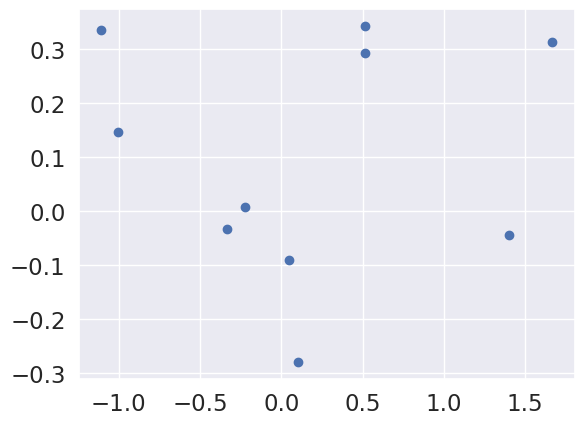

In [24]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

5. Creacion del modelo como PKL

In [25]:
from joblib import dump
dump(regresion, './model/model-profit.pkl')

['./model/model-profit.pkl']